In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

import datetime

import gym
import trading_env

import os
import agent 
from os import __file__

Using TensorFlow backend.


Loading historical data file


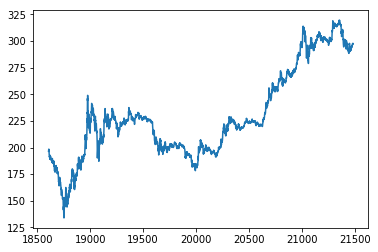

In [2]:
env_trading = gym.make('test_trading-v0')
NUM_EP = 400
date = datetime.datetime(2017, 7, 15, 0, 0)
data = env_trading.historical_data["close"]
env_trading.reset(date=date)
plt.plot(data[env_trading.start_index:env_trading.start_index + int(env_trading.episode_steps) 
              if env_trading.start_index + int(env_trading.episode_steps) < data.shape[0]
             else data.shape[0]])

plt.show()

Loading historical data file


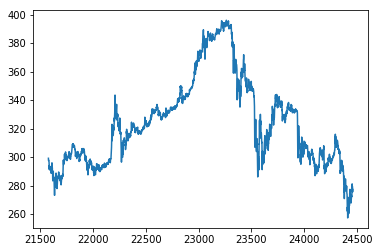

In [ ]:
env_trading_test = gym.make('test_trading-v0')
date_test = datetime.datetime(2017, 8, 15, 0, 0)
data = env_trading_test.historical_data["close"]
env_trading_test.reset(date=date_test)
plt.plot(data[env_trading_test.start_index:env_trading_test.start_index + int(env_trading_test.episode_steps) 
              if env_trading_test.start_index + int(env_trading_test.episode_steps) < data.shape[0]
             else data.shape[0]])

plt.show()

## The Goal
Have a better cumulated reward and final portfolio value than the three following agents:
- The "holder" (action = 1)
- The "All out" (action = -1)
- The "I have no idea what I am doing" (random action)


# Holder

In [ ]:
state = env_trading.reset(date=date)
total_reward = 0

while(True):
    action = 1.0 #Holder agent
    state, reward, done, _ = env_trading.step(action)
    total_reward += reward
    if done:
        break
holder_reward = np.full(NUM_EP, total_reward)

# Random

In [ ]:
state = env_trading.reset(date=date)
total_reward = 0

while(True):
    action = env_trading.action_space.sample()
    state, reward, done, _ = env_trading.step(action)
    total_reward += reward
    if done:  
        break
random_reward = np.full(NUM_EP, total_reward)

# All out

In [ ]:
out_reward = np.full(NUM_EP, 0)

# The Agent

### Stochastic Policy Gradient

In [ ]:
agentSPG = agent.StochasticPolicyGradientAgent(env_trading, learning_rate = 1e-4, 
                                               discount_rate = 0.99, batch_size = 64)

In [ ]:
rewards_plot = []
portfolio = []
for i in range(NUM_EP):
    state = env_trading.reset(date=date)
    state = np.reshape(state,200)
    total_reward = 0
    
    while(True):
        action = agentSPG.act([state])
        print(action)
        state, reward, done, _ = env_trading.step(action)
        state = np.reshape(state,200)
        agentSPG.store_step(action, state, reward)
        total_reward += reward
        if done:
            rewards_plot.append(total_reward)
            portfolio.append(env_trading.portfolio_value)
            print("Episode: {}, Total reward: {}".format(i,total_reward))
            break
    agentSPG.train()


In [ ]:
plt.plot(rewards_plot, label = "Trained agent")
plt.plot(holder_reward, label = "Holder")
plt.plot(random_reward, label = "Random")
plt.plot(out_reward, label = "All out")
plt.legend()
plt.show()

### Deep Q Network

In [ ]:
agentDQN = agent.DQNAgent(env_trading, alpha = 1e-3, epsilon_log_decay = 0.5)

In [ ]:
rewards_plot = []
rewards_plot_test = []

date = datetime.datetime(2017, 7, 15, 0, 0)
date_test = datetime.datetime(2017, 8, 15, 0, 0)

for e in range(NUM_EP):

    state = np.reshape(env_trading.reset(date=date), [1, 200])
    state_test = np.reshape(env_trading_test.reset(date=date_test), [1, 200])
    score = 0
    score_test = 0
    
    while(True):
        action = agentDQN.act(state, step = e)
        next_state, reward, done, _ = env_trading.step(action - 1) #Converting class to action
        next_state = np.reshape(next_state, [1, 200])

        agentDQN.store_step(state, action, reward, next_state, done)

        state = next_state

        score += reward

        if done:
            rewards_plot.append(score)
            print("Episode: {}, Total reward: {}".format(e, score))
            break
            
    while(True):
        action_test = agentDQN.act(state_test)
        state_test, reward_test, done_test, _ = env_trading_test.step(action_test - 1) #Converting class to action
        state_test = np.reshape(state_test, [1, 200])
        score_test += reward_test
        if done_test:
            rewards_plot_test.append(score_test)
            print("Final test cumulated reward: {}".format(score_test))
            break
    
    agentDQN.train()

In [ ]:
plt.plot(rewards_plot, label = "Trained agent")
plt.plot(holder_reward, label = "Holder")
plt.plot(random_reward, label = "Random")
plt.plot(out_reward, label = "All out")
plt.legend()
plt.show()

The DQN agent is able to have a greater cumulated reward than the 3 other agents.

### Testing

In [ ]:
plt.plot(rewards_plot_test, label = "Trained agent (Test)")
plt.legend()
plt.show()

### DDPG

In [ ]:
agentDDPG = agent.DDPGAgent(env_trading, epsilon_log_decay=0.5) #Do not run after running DQN, to correct!

Defining exploration noise

In [ ]:
# Ornstein-Uhlenbeck noise by lirnli/OpenAI-gym-solutions

def UONoise():
    theta = 0.15
    sigma = 0.2
    state = 0
    while True:
        yield state
        state += -theta*state+sigma*np.random.randn()

In [ ]:
date = datetime.datetime(2017, 7, 15, 0, 0)
noise = UONoise()
scores = []

for e in range(NUM_EP):
    state = np.reshape(env_trading.reset(date=date), 200)
    score = 0
    p = e/NUM_EP

    while(True):
        action = agentDDPG.actor.act([state], step = e)
        next_state, reward, done, _ = env_trading.step(action)
        next_state = np.reshape(next_state, 200)
        score += reward
        
        agentDDPG.store_step(state, action, reward, next_state)

        if done:
            agentDDPG.train()
            scores.append(score)
            print("Episode: {}, Total reward: {}".format(e, score))
            break
        state = next_state

In [ ]:
plt.plot(scores, label = "Trained agent")
plt.plot(holder_reward, label = "Holder")
plt.plot(random_reward, label = "Random")
plt.plot(out_reward, label = "All out")
plt.legend()
plt.show()

### Testing

In [ ]:
date = datetime.datetime(2017, 7, 15, 0, 0) # Next month
state = np.reshape(env_trading.reset(date=date), 200)
score = 0
while(True):
    action = agentDDPG.actor.act([state])
    state, reward, done, _ = env_trading.step(action)
    state = np.reshape(state, 200)
    score += reward
    if done:
        print("Final cumulated reward: {}".format(score))
        break

In [ ]:
params = agentDDPG.critic._sess.run(agentDDPG.critic.target_network_params)
p = [p.shape for p in params]
print(p)

In [ ]:
type(env_trading.action_space.sample()[0])